In [1]:
import torch
import gpytorch
import copy
from matplotlib import pyplot as plt
import itertools
import numpy as np
import pandas as pd
from datetime import datetime
from skimage.measure import block_reduce
from pathlib import Path
import math
from datetime import datetime
import gc
import sys
import os
sys.path.append(Path(os.getcwd()).parent.__str__())
from src.utils import *
plt.style.use('classic')
set_gpytorch_settings(False)
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
torch.manual_seed(0)
# Training data is 11 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 10000)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

train_x = train_x.cuda()
train_y = train_y.cuda()
model = model.cuda()
likelihood = likelihood.cuda()



In [3]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.790   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.748   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.708   lengthscale: 0.599   noise: 0.598
Iter 4/50 - Loss: 0.669   lengthscale: 0.557   noise: 0.554
Iter 5/50 - Loss: 0.630   lengthscale: 0.520   noise: 0.513
Iter 6/50 - Loss: 0.592   lengthscale: 0.487   noise: 0.474
Iter 7/50 - Loss: 0.555   lengthscale: 0.457   noise: 0.437
Iter 8/50 - Loss: 0.517   lengthscale: 0.431   noise: 0.403
Iter 9/50 - Loss: 0.479   lengthscale: 0.409   noise: 0.370
Iter 10/50 - Loss: 0.441   lengthscale: 0.389   noise: 0.340
Iter 11/50 - Loss: 0.404   lengthscale: 0.371   noise: 0.312
Iter 12/50 - Loss: 0.366   lengthscale: 0.356   noise: 0.286
Iter 13/50 - Loss: 0.328   lengthscale: 0.343   noise: 0.262
Iter 14/50 - Loss: 0.291   lengthscale: 0.331   noise: 0.240
Iter 15/50 - Loss: 0.253   lengthscale: 0.321   noise: 0.219
Iter 16/50 - Loss: 0.217   lengthscale: 0.312   noise: 0.200
Iter 17/50 - Loss: 0.180   length

In [4]:
test_x = torch.linspace(0, 1, 51).cuda()

In [5]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    mean = observed_pred.mean
    lower, upper = observed_pred.confidence_region()

/home/dcaos/anaconda3/envs/MLconda/lib/python3.10/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


In [6]:
# mean = mean.detach().cpu()
# lower = lower.detach().cpu()
# upper = upper.detach().cpu()
#
# train_x = train_x.detach().cpu()
# train_y = train_y.detach().cpu()
# test_x = test_x.detach().cpu()

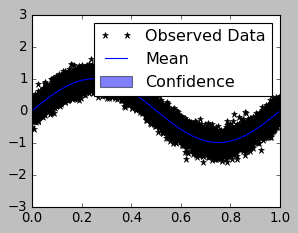

In [7]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Plot training data as black stars
    ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.cpu().numpy(), mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [8]:
with torch.no_grad():
    model.train()
    likelihood.train()
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model).cuda()
    f = model(train_x)
    l = mll(f, train_y)  # log marginal likelihood
    num_param = sum(p.numel() for p in model.hyperparameters())
    BIC = -l * train_y.shape[0] + num_param / 2 * torch.tensor(train_y.shape[0]).log()
print(BIC.item())

-1779.3282470703125


In [9]:
start_time = time.time()
steps = [500, 600, 700, 800]
err_list = []
for idx_ahead in steps:
    # print(iter)
    with torch.no_grad():
        # picks index in the second half of the observed data
        # print(idx_ahead)
        # going to be the new "training" set; from t=0 to t=idx_ahead-1
        temp_x_train = train_x[:idx_ahead]
        temp_y_train = train_y[:idx_ahead]
        # this is the new "testing" set: from t=idx_ahead, ..., t=idx_ahead+6
        # temp_x_test = self.train_x[idx_ahead:(idx_ahead+test_n_points_ahead)]
        # temp_y_test = self.train_y[idx_ahead:(idx_ahead+test_n_points_ahead)]
        temp_x_test = train_x[idx_ahead:(idx_ahead+10)]
        temp_y_test = train_y[idx_ahead:(idx_ahead+10)]
        # self.trained_model.set_train_data(
        # model.train()

        model.set_train_data(
            inputs=temp_x_train, targets=temp_y_train, strict=False)
        # self.trained_model.eval()
        # gc.collect()
        # torch.cuda.empty_cache()
        model.eval()
        # grab the evaluated model predictions
        f = model(temp_x_test)
        # calculate the error (MSE) for the prediction
        err = torch.mean((f.mean - temp_y_test)**2).sqrt().item()
        err_list.append(err)
print("--- %s seconds ---" % (time.time() - start_time))
print(err_list)
print(np.nanmean(err_list))

--- 0.020229578018188477 seconds ---
[0.16682414710521698, 0.21752621233463287, 0.2467321902513504, 0.17085567116737366]
0.20048455521464348


--- 87.04527473449707 seconds ---
[0.6033238172531128, 0.6230283379554749, 0.8090763688087463, 0.8092657327651978, 0.7999988198280334, 0.901354968547821, 0.5693684220314026, 0.6072689294815063, 0.7313937544822693, 0.68719083070755, 0.558936357498169, 0.8089842200279236, 0.6528764963150024, 0.6712214946746826, 0.7931537628173828, 0.8205239772796631, 0.8263500928878784, 0.8596473336219788, 0.7953019142150879, 0.8693141937255859, 0.6168981194496155, 0.7209643721580505, 0.7825726270675659, 0.7398408651351929, 0.8676556348800659, 0.6510311365127563, 0.599179744720459, 0.5488998889923096, 0.6251786947250366, 0.6364132761955261, 0.6513168215751648, 0.7165092825889587, 0.7368254661560059, 0.9094812870025635, 0.6463890075683594, 0.5923132300376892, 0.5926024913787842, 0.6659847497940063, 0.6491590738296509, 0.6413748264312744, 0.7296459674835205, 0.7459658980369568, 0.8277745842933655, 0.6903091669082642, 0.6709650158882141, 0.6525619626045227, 0.7554639577865601, 0.6437652111053467, 0.87017381

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.603324,0.623028,0.809076,0.809266,0.799999,0.901355,0.569368,0.607269,0.731394,0.687191,...,0.754267,0.618499,0.678208,0.635609,0.746351,0.663076,0.768170,0.895846,0.752060,0.728175
1,-1762.867310,-1774.759155,-1791.830688,-1769.330322,-1790.157104,-1783.339722,-1760.616455,-1775.085449,-1845.168335,-1786.392090,...,-1791.079346,-1776.966553,-1791.109863,-1783.491821,-1863.548462,-1863.509399,-1776.887817,-1780.953979,-1766.285767,-1789.625854


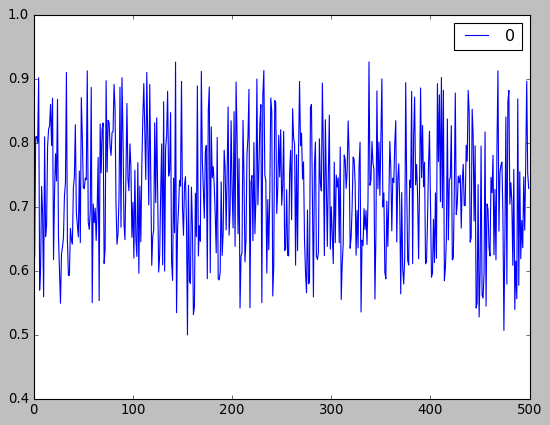

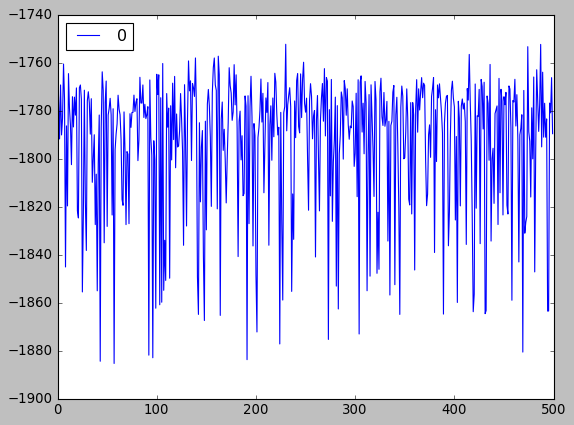

In [10]:
start_time = time.time()
n_total = train_x.shape[0]
steps = np.random.randint(low=n_total/2,high=n_total-test_x.shape[0], size=500)
err_list = []
bic_list = []
for idx_ahead in steps:
    # print(iter)
    with torch.no_grad():
        # picks index in the second half of the observed data
        # print(idx_ahead)
        # going to be the new "training" set; from t=0 to t=idx_ahead-1
        temp_x_train = train_x[:idx_ahead]
        temp_y_train = train_y[:idx_ahead]
        # this is the new "testing" set: from t=idx_ahead, ..., t=idx_ahead+6
        temp_x_test = train_x[idx_ahead:(idx_ahead+51)]
        temp_y_test = train_y[idx_ahead:(idx_ahead+51)]
        model.train()
        model.set_train_data(
            inputs=temp_x_train, targets=temp_y_train, strict=False)
        # grab the evaluated model predictions
        f = model(temp_x_train)
        l = mll(f, temp_y_train)  # log marginal likelihood
        num_param = sum(p.numel() for p in model.hyperparameters())
        BIC = (-l * train_y.shape[0] + num_param / 2 * torch.tensor(train_y.shape[0]).log()).item()

        model.eval()
        f = model(temp_y_test)
        # calculate the error (MSE) for the prediction
        err = torch.mean((f.mean - temp_y_test)**2).sqrt().item()
        err_list.append(err)
        bic_list.append(BIC)
        # metric_list.append([err, BIC])
print("--- %s seconds ---" % (time.time() - start_time))
print(err_list)

with torch.no_grad():
    model.train()
    likelihood.train()
    model.set_train_data(
            inputs=train_x, targets=train_y, strict=False)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model).cuda()
    f = model(train_x)
    l = mll(f, train_y)  # log marginal likelihood
    num_param = sum(p.numel() for p in model.hyperparameters())
    BIC = -l * train_y.shape[0] + num_param / 2 * torch.tensor(train_y.shape[0]).log()
print(BIC.item())


# print(np.nanmean(err_list[:][0]), np.nanmean(err_list[:][1]))
metric_df = pd.DataFrame([err_list, bic_list])
err_df = pd.DataFrame(err_list)
bic_df = pd.DataFrame(bic_list)

err_df.plot()
bic_df.plot()

metric_df

In [11]:
# # Get into evaluation (predictive posterior) mode
# model.eval()
# likelihood.eval()
#
# # Test points are regularly spaced along [0,1]
# # Make predictions by feeding model through likelihood
# with torch.no_grad(), gpytorch.settings.fast_pred_var():
#     observed_pred = likelihood(model(test_x))
#     mean = observed_pred.mean
#     lower, upper = observed_pred.confidence_region()

In [12]:
with torch.no_grad():
    model.train()
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model).cuda()
    model.eval()
    f = model(train_x)
    l = mll(f, train_y)  # log marginal likelihood
    num_param = sum(p.numel() for p in model.hyperparameters())
    BIC = -l * train_y.shape[0] + num_param / 2 * torch.tensor(train_y.shape[0]).log()
print(BIC.item())

/home/dcaos/anaconda3/envs/MLconda/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:283: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


-1810.1651611328125


In [14]:
start_time = time.time()
steps = np.random.randint(low=n_total/2,high=n_total-test_x.shape[0], size=500)
err_list = []
for idx_ahead in steps:
    # print(iter)
    with torch.no_grad():
        # picks index in the second half of the observed data
        # print(idx_ahead)
        # going to be the new "training" set; from t=0 to t=idx_ahead-1
        temp_x_train = train_x[:idx_ahead]
        temp_y_train = train_y[:idx_ahead]
        # this is the new "testing" set: from t=idx_ahead, ..., t=idx_ahead+6
        # temp_x_test = self.train_x[idx_ahead:(idx_ahead+test_n_points_ahead)]
        # temp_y_test = self.train_y[idx_ahead:(idx_ahead+test_n_points_ahead)]
        temp_x_test = train_x[idx_ahead:(idx_ahead+10)]
        temp_y_test = train_y[idx_ahead:(idx_ahead+10)]
        # self.trained_model.set_train_data(
        # model.train()

        model.set_train_data(
            inputs=temp_x_train, targets=temp_y_train, strict=False)
        # self.trained_model.eval()
        # gc.collect()
        # torch.cuda.empty_cache()
        model.eval()
        # grab the evaluated model predictions
        f = model(temp_x_test)
        # calculate the error (MSE) for the prediction
        err = torch.mean((f.mean - temp_y_test)**2).sqrt().item()
        err_list.append(err)
print("--- %s seconds ---" % (time.time() - start_time))
print(err_list)
print(np.nanmean(err_list))

--- 56.54836988449097 seconds ---
[0.12579496204853058, 0.15993858873844147, 0.11364570260047913, 0.2015327513217926, 0.21983762085437775, 0.16336560249328613, 0.19167719781398773, 0.3053427040576935, 0.1982675939798355, 0.2267415076494217, 0.19988717138767242, 0.19411370158195496, 0.19185301661491394, 0.19892384111881256, 0.23333579301834106, 0.1516145020723343, 0.2611902952194214, 0.22933441400527954, 0.1520630270242691, 0.2708333134651184, 0.24596479535102844, 0.1832261085510254, 0.17514298856258392, 0.2695598304271698, 0.18542331457138062, 0.22000916302204132, 0.21507319808006287, 0.2837790548801422, 0.2307748794555664, 0.22597116231918335, 0.23161187767982483, 0.14994876086711884, 0.26853930950164795, 0.1643930971622467, 0.2149154096841812, 0.25351500511169434, 0.22570854425430298, 0.24425463378429413, 0.10333897918462753, 0.18689915537834167, 0.12964265048503876, 0.18659855425357819, 0.10771812498569489, 0.2570386230945587, 0.2555942237377167, 0.20918342471122742, 0.2146550416946